### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import tensorflow as tf
import seaborn as sns
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
import sys
import time
import shap
import lime
from lime import lime_tabular

### Data Preprocessing

In [3]:
file_path = "C:/Users/Dell/Downloads/SY_NG/Myfile_dataA_5000.csv"
csvFile = pd.read_csv(file_path)

In [4]:
csvFile.shape

(5000, 9)

In [5]:
csvFile = csvFile.dropna()

In [6]:
csvFile.isna().sum()

Gate_Length          0
Work_function        0
Channel_Thickness    0
Oxide_Thickness      0
SD_doping            0
SUBSTRATE_doping     0
Gate_Voltage         0
Drain_Voltage        0
Drain Current        0
dtype: int64

In [7]:
csvFile.head()

,Gate_Length,Work_function,Channel_Thickness,Oxide_Thickness,SD_doping,SUBSTRATE_doping,Gate_Voltage,Drain_Voltage,Drain Current
0,1.220000e-08,4.606941,1.090000e-08,1.350000e-09,3.700000e+20,1.130000e+17,0.078664,0.216504,2.070000e-12
1,1.900000e-08,4.492014,1.090000e-08,1.360000e-09,4.060000e+20,2.210000e+17,0.496761,0.591274,2.120000e-12
2,1.080000e-08,4.331288,1.020000e-08,1.090000e-09,6.650000e+20,2.660000e+17,0.185672,0.798587,2.160000e-12
3,1.340000e-08,4.081299,1.010000e-08,1.200000e-09,4.820000e+20,2.490000e+17,0.166393,0.878277,2.210000e-12
4,1.440000e-08,4.254729,1.080000e-08,1.780000e-09,6.530000e+20,2.630000e+17,0.764250,0.111511,2.260000e-12


In [8]:
num_features = ["Gate_Length", "Work_function", "Channel_Thickness", "Oxide_Thickness", 
                "SD_doping", "SUBSTRATE_doping", "Gate_Voltage", "Drain_Voltage"]
X = csvFile[num_features]
y = csvFile["Drain Current"]

In [9]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

### Data Splitting (80% Training Data and 20% Testing Data)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 44) (4000,)
(1000, 44) (1000,)


### Model: Random Forest Regressor

In [22]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

In [24]:
RFR = RandomForestRegressor(random_state=42, oob_score=True)
random_search = RandomizedSearchCV(RFR, param_distributions=param_grid, n_iter=100, cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [20, 30, 40, 50],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [500]},
                   random_state=42, scoring='r2')

In [25]:
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}


In [26]:
y_pred = best_rf.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Erro:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2_score = metrics.r2_score(y_test, y_pred)
print('R² Score:', r2_score)

Mean Absolute Error: 4.054111496195186e-09
Mean Squared Erro: 4.945071997827062e-17
Root Mean Squared Error: 7.03212058900234e-09
R² Score: 0.9996289594812433


### Overfitting Analysis - Learning Curve and Cross-Validation

In [28]:
train_sizes, train_scores, test_scores = learning_curve(best_rf, x_train, y_train, cv=5, scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

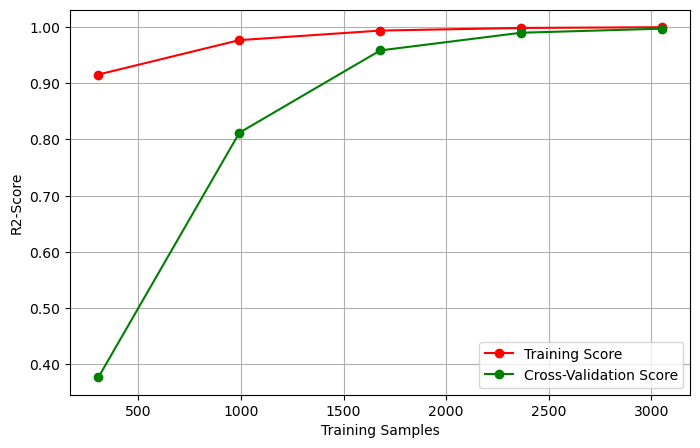

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('R2-Score')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.grid()
plt.show()

### Model Inference Time

In [40]:
num_inferences = 100

start_time = time.time()

for _ in range(num_inferences):
    predictions = best_rf.predict(x_test)

end_time = time.time()

average_inference_time = (end_time - start_time) / num_inferences
print(f"Average inference time for ML model: {average_inference_time:.6f} seconds")

Average inference time for ML model: 0.071822 seconds


### SHAP

In [32]:
explainer = shap.Explainer(best_rf.predict, x_train)

In [33]:
shap_values = explainer(x_test)

PermutationExplainer explainer: 956it [2:58:13, 11.20s/it]                           


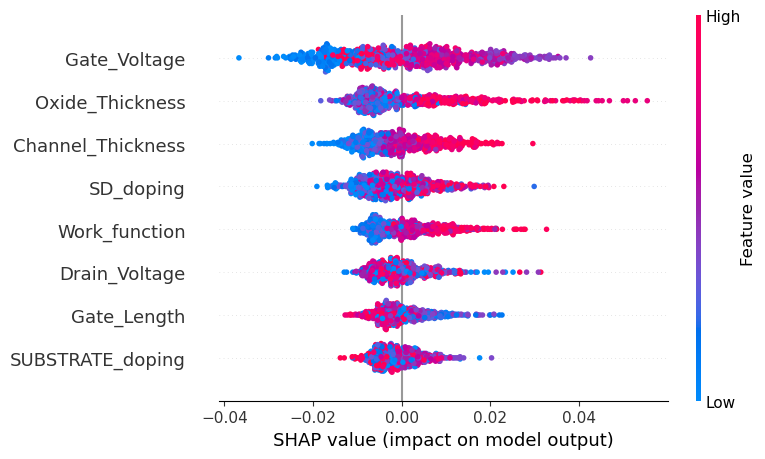

In [21]:
# Summary plot of feature importance
shap.summary_plot(shap_values, x_test, show=False)
plt.savefig("RF_shap_summary_plot.png", dpi=300, bbox_inches='tight')

In [22]:
shap_values.shape

(750, 8)

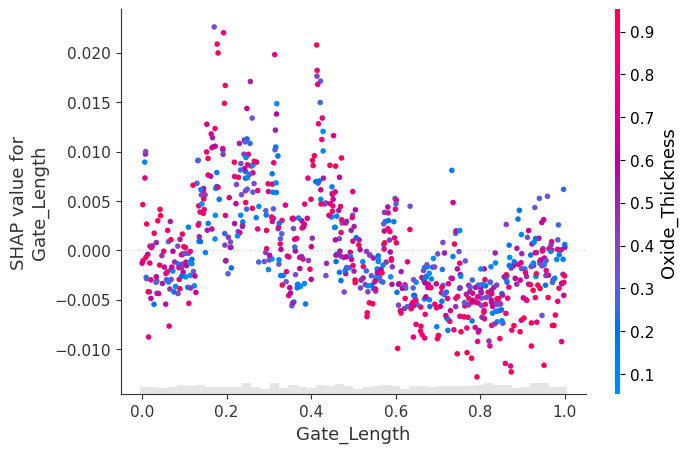

In [23]:
shap.plots.scatter(shap_values[:, 0], color=shap_values, show=False)
plt.savefig("RF_shap_scatter_plot_1.png", dpi=300, bbox_inches='tight')

In [24]:
shap.plots.waterfall(shap_values[749], show=False)
plt.savefig("RF_shap_waterfall_plot.png", dpi=300, bbox_inches='tight')

In [25]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("RF_shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

### LIME

In [36]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns, mode='regression')

In [37]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(), class_names=['MEDV'], 
                                                   verbose=True, mode='regression')

In [38]:
j = 5
exp = explainer.explain_instance(x_test.values[j], RFR.predict, num_features=6)

Intercept 0.06796534287126192
Prediction_local [0.05098635]
Right: 0.02537195279909789


In [39]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("RF_lime_explanation_plot_1.png", dpi=300, bbox_inches='tight')

In [40]:
exp.as_list()

[('Gate_Voltage <= 0.24', -0.023725592998389767),
 ('Work_function > 0.75', 0.013442831346310559),
 ('Channel_Thickness <= 0.25', -0.010212740789360963),
 ('Oxide_Thickness <= 0.26', -0.007625163056074132),
 ('0.25 < Drain_Voltage <= 0.50', 0.007281009722224118),
 ('0.24 < Gate_Length <= 0.49', 0.0038606619882183444)]

In [41]:
j = 5
exp = explainer.explain_instance(x_test.values[j], RFR.predict, num_features=6)

Intercept 0.06864900279599115
Prediction_local [0.04892977]
Right: 0.025371952799097888


In [42]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("RF_lime_explanation_plot_1.png", dpi=300, bbox_inches='tight')

In [43]:
exp.as_list()

[('Gate_Voltage <= 0.24', -0.023525869552792174),
 ('Work_function > 0.75', 0.011983170836126718),
 ('Channel_Thickness <= 0.25', -0.009952420516839134),
 ('Oxide_Thickness <= 0.26', -0.006734219137923092),
 ('0.25 < Drain_Voltage <= 0.50', 0.004743550099189276),
 ('0.24 < Gate_Length <= 0.49', 0.0037665585512350916)]

### How Random Forest Model Influences eXplainable AI (XAI)

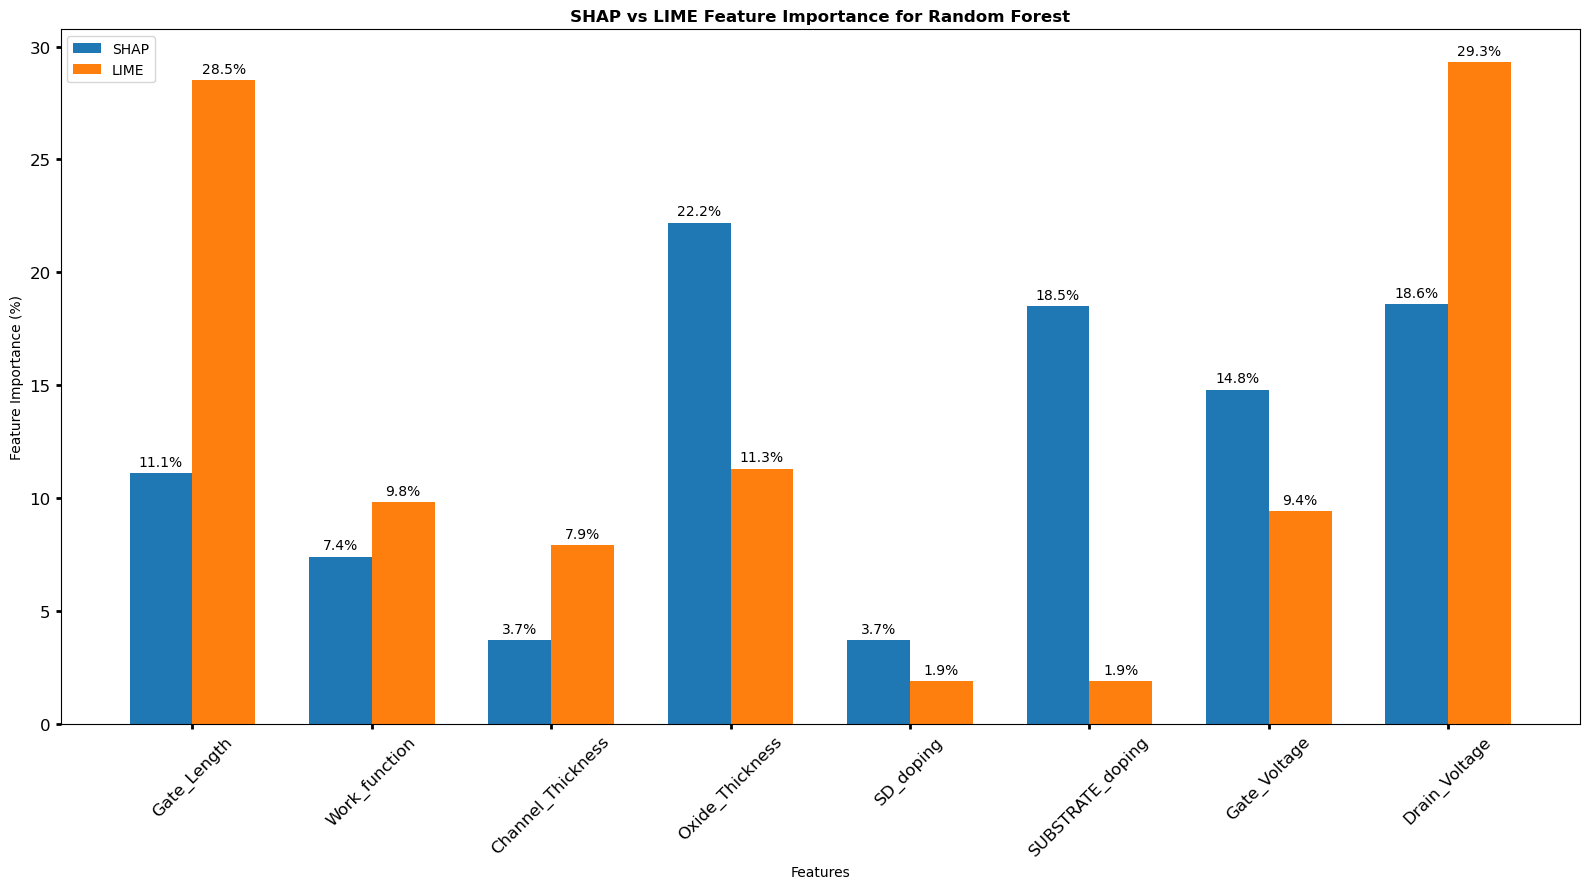

In [5]:
features = ['Gate_Length', 'Work_function', 'Channel_Thickness', 'Oxide_Thickness',
            'SD_doping', 'SUBSTRATE_doping', 'Gate_Voltage', 'Drain_Voltage']

shap_values = {
    'Random Forest': [11.1, 7.4, 3.7, 22.2, 3.7, 18.5, 14.8, 18.6],
}

lime_values = {
    'Random Forest': [28.5, 9.8, 7.9, 11.3, 1.9, 1.9, 9.4, 29.3],
}

def plot_feature_importance(shap_values, lime_values, model_name):
    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 9))
    
    rects1 = ax.bar(x - width/2, shap_values, width, label='SHAP')
    rects2 = ax.bar(x + width/2, lime_values, width, label='LIME')

    ax.set_xlabel('Features')
    ax.set_ylabel('Feature Importance (%)')
    ax.set_title(f'SHAP vs LIME Feature Importance for {model_name}', fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12, width=2)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

for model_name in shap_values.keys():
    plot_feature_importance(shap_values[model_name], lime_values[model_name], model_name)